In [33]:
#!pip install vectorbt
#!pip install apimoex

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import vectorbt as vbt
import numpy as np
import requests
import apimoex
import plotly.graph_objects as go
import vectorbt as vbt

In [4]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2018, 12, 31)
with requests.Session() as session:
    data = apimoex.get_market_candles(session, 'GAZP', interval=60, start= start, end=end)
    df = pd.DataFrame(data)
    df.set_index(pd.to_datetime(df['begin']), inplace=True)
    df.drop(['begin'], axis=1, inplace=True)

df = df[[ "open", "high", "low", "close"]]
df.head(3)

,open,high,low,close
begin,,,,
2018-01-03 09:00:00,131.03,131.03,131.03,131.03
2018-01-03 10:00:00,131.03,131.75,130.63,131.40
2018-01-03 11:00:00,131.35,131.87,131.20,131.21


##### money – стартовое количество денежных единиц (100 000 )
##### start – дата старта временного интервала ( 2018-1-3)
##### finish – дата финиша временного интервала ( 2018-12-29)
##### stop_loss – в процентах (5%)
##### fast_window – размер быстрого скользящего окна (30 торговых свечей)
##### slow_window – размер медленного скользящего окна (90 торговых свечей) в окнах считаем простое скользящее среднее
##### Используем часовые временные интeрвалы.

In [5]:
money = 100000
stop_loss = 0.05
fast_window = 30
slow_window = 90

In [6]:
fast_window = vbt.MA.run(df['close'], window = 30)
df['fast_window']= fast_window.ma

In [7]:
slow_window = vbt.MA.run(df['close'], window =90)
df['slow_window']= slow_window.ma
df

,open,high,low,close,fast_window,slow_window
begin,,,,,,
2018-01-03 09:00:00,131.03,131.03,131.03,131.03,NaN,NaN
2018-01-03 10:00:00,131.03,131.75,130.63,131.40,NaN,NaN
2018-01-03 11:00:00,131.35,131.87,131.20,131.21,NaN,NaN
2018-01-03 12:00:00,131.27,131.66,131.05,131.46,NaN,NaN
2018-01-03 13:00:00,131.45,131.58,131.19,131.32,NaN,NaN
...,...,...,...,...,...,...
2018-12-29 14:00:00,153.19,153.34,152.91,153.30,151.733333,150.654556
2018-12-29 15:00:00,153.34,153.48,153.14,153.47,151.876667,150.678111
2018-12-29 16:00:00,153.45,153.50,153.05,153.21,152.043667,150.703000


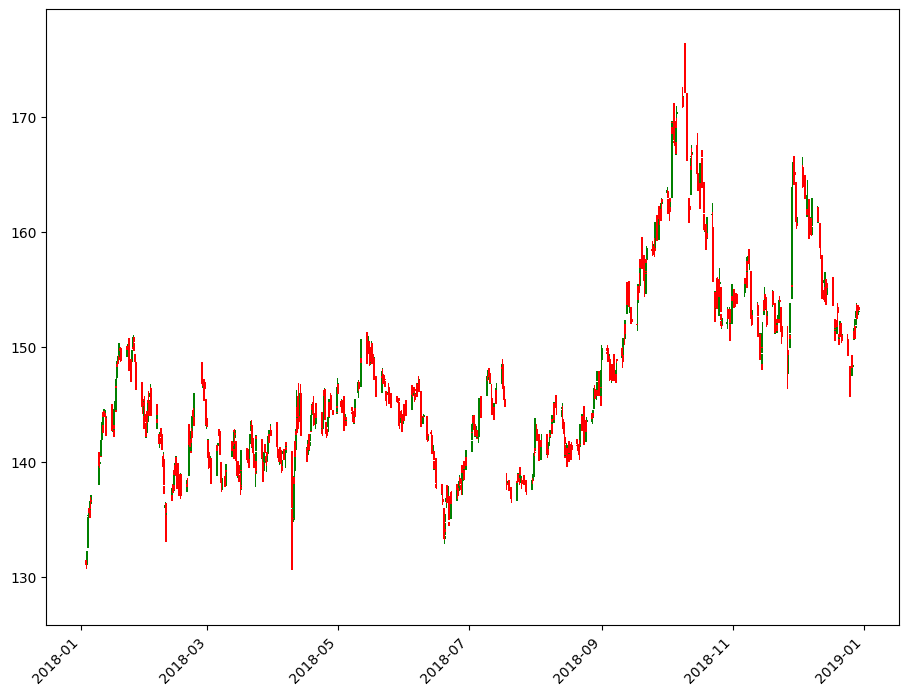

In [34]:
# Настройка размера графика
plt.figure(figsize=(11, 8))

# Параметры отображения свечей
CANDLE_WIDTH = 0.9
WICK_WIDTH = 0.1
GREEN_COLOR = 'green'
RED_COLOR = 'red'

# Разделение данных
bullish_candles = df[df.close >= df.open]
bearish_candles = df[df.close < df.open]

# Отрисовка восходящих свечей (зеленых)
plt.bar(bullish_candles.index,
        bullish_candles.close - bullish_candles.open,
        width=CANDLE_WIDTH,
        bottom=bullish_candles.open,
        color=GREEN_COLOR)

plt.bar(bullish_candles.index,
        bullish_candles.high - bullish_candles.close,
        width=WICK_WIDTH,
        bottom=bullish_candles.close,
        color=GREEN_COLOR)

plt.bar(bullish_candles.index,
        bullish_candles.low - bullish_candles.open,
        width=WICK_WIDTH,
        bottom=bullish_candles.open,
        color=GREEN_COLOR)

# Отрисовка нисходящих свечей (красных)
plt.bar(bearish_candles.index,
        bearish_candles.close - bearish_candles.open,
        width=CANDLE_WIDTH,
        bottom=bearish_candles.open,
        color=RED_COLOR)

plt.bar(bearish_candles.index,
        bearish_candles.high - bearish_candles.open,
        width=WICK_WIDTH,
        bottom=bearish_candles.open,
        color=RED_COLOR)

plt.bar(bearish_candles.index,
        bearish_candles.low - bearish_candles.close,
        width=WICK_WIDTH,
        bottom=bearish_candles.close,
        color=RED_COLOR)

# Настройка осей
plt.xticks(rotation=45, ha='right')

# Отображение графика
plt.show()

График, отражающий цену закрытия каждого интервала, сверху быстрая и медленная скользящие средние.

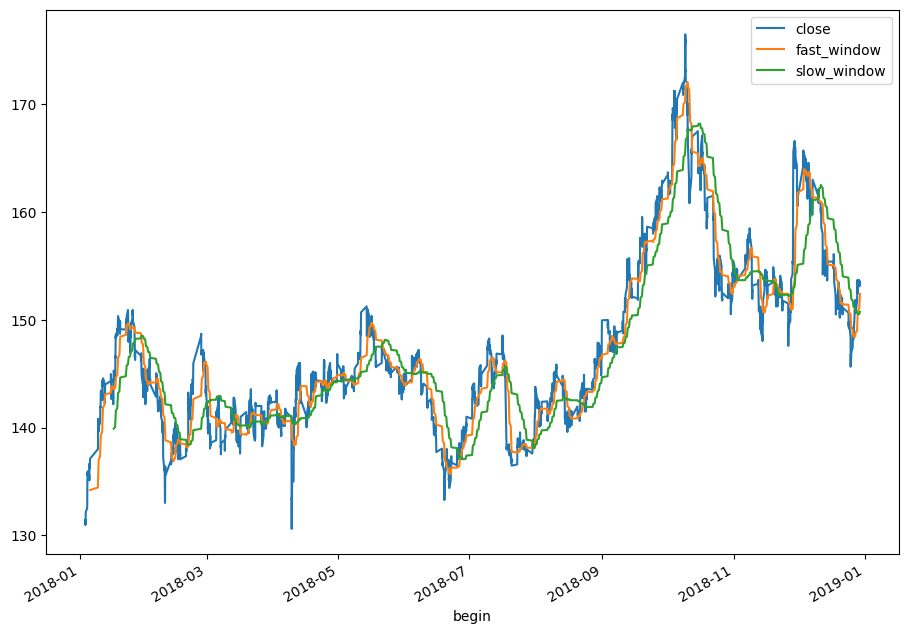

In [9]:
df[['close', 'fast_window', 'slow_window']].plot(figsize=(11,8))
plt.show()

In [11]:
# Определим сигналы на покупку и продажу
entries = fast_window.ma_crossed_above(slow_window)
exits = fast_window.ma_crossed_below(slow_window)
#stop_loss_exits = entries.vbt.signals.generate_stop_exits(stoks_close, -stop_loss)
#exits = stop_loss_exits | exits


In [12]:
entries_2 = entries.copy()

In [13]:
entries_2 = pd.DataFrame(entries_2, columns=["signal"])
entries_2["signal"] = entries_2["signal"].astype(int)
#entries_2.plot()

In [14]:
exits_2 = exits.copy()

In [15]:
exits_2 = pd.DataFrame(exits_2, columns=["signal"])
exits_2["signal"] = exits_2["signal"].astype(int)

In [16]:
df_merged = pd.merge(entries_2,exits_2, on = 'begin')
df_merged['signals'] = [0]*len(df_merged)
df_merged = df_merged.rename(columns = {'signal_x' : 'buy', 'signal_y': 'sell'})
display(df_merged)

,buy,sell,signals
begin,,,
2018-01-03 09:00:00,0,0,0
2018-01-03 10:00:00,0,0,0
2018-01-03 11:00:00,0,0,0
2018-01-03 12:00:00,0,0,0
2018-01-03 13:00:00,0,0,0
...,...,...,...
2018-12-29 14:00:00,0,0,0
2018-12-29 15:00:00,0,0,0
2018-12-29 16:00:00,0,0,0


In [17]:
f = False
for index, row in df_merged.iterrows():
    if row['buy'] == 1 :
        f = True
    if row['sell'] == 1 :
        f = False
    if f == True:
        df_merged.loc[index, "signals"] = 1
    if f == False:
        df_merged.loc[index, "signals"] = 0

In [18]:
df_merged['signals'].value_counts()

,count
signals,
1,1281
0,1259


<Axes: xlabel='begin'>

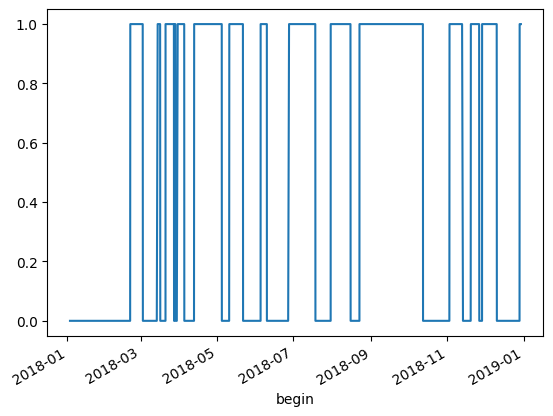

In [19]:
df_merged['signals'].plot()

In [20]:
f = vbt.Portfolio.from_signals(df['close'], entries, exits, init_cash= money, freq='1h', sl_stop=stop_loss)
fig = f.plot(subplots=['orders','trade_pnl','cum_returns'])
fast_window.ma.vbt.plot(fig=fig)
slow_window.ma.vbt.plot(fig=fig)
fig.show()

In [21]:
f.stats()

,0
Start,2018-01-03 09:00:00
End,2018-12-29 18:00:00
Period,105 days 20:00:00
Start Value,100000.0
End Value,94295.838619
Total Return [%],-5.704161
Benchmark Return [%],17.148745
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],16.386242


Посчитаем общкю прибыль

In [22]:
print(f.total_profit())

-5704.161380556921


In [23]:
# Определение функции для расчета прибыли
def calculate_profit(fast_window, slow_window):
    df['fast_window'] = vbt.MA.run(df['close'], window=fast_window).ma
    df['slow_window'] = vbt.MA.run(df['close'], window=slow_window).ma
    df['signal'] = np.where(df['fast_window'] > df['slow_window'], 1.0, 0.0)
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    df['cumulative_strategy_returns'] = df['strategy_returns'].cumsum()
    # Use .iloc[-1] instead of [-1] for position-based indexing
    return df['cumulative_strategy_returns'].iloc[-1]

In [24]:
# Определение диапазонов для быстрой и медленной скользящих средних
fast_window_range = np.arange(5, 51, dtype=int)
slow_window_range = np.arange(50, 201, dtype=int)

In [25]:
# матрица результатов
results = np.zeros((len(fast_window_range), len(slow_window_range)))

In [26]:
# Цикл для расчета прибыли для каждого сочетания быстрой и медленной скользящих средних
for i, fast_window in enumerate(fast_window_range):
    for j, slow_window in enumerate(slow_window_range):
        results[i, j] = calculate_profit(fast_window, slow_window)

In [29]:
max = np.max(results)
max = max*money
print(f'{max:.2f}')

23042.07


In [30]:
# Поиск оптимального сочетания быстрой и медленной скользящих средних
max_profit = np.max(results)
optimal_fast_window = fast_window_range[np.unravel_index(np.argmax(results), results.shape)[0]]
optimal_slow_window = slow_window_range[np.unravel_index(np.argmax(results), results.shape)[1]]

print(f'Оптимальный размер быстрой скользящей средней: {optimal_fast_window}')
print(f'Оптимальный размер медленной скользящей средней: {optimal_slow_window}')
print(f'Максимальная прибыль: {max_profit:.2f}%')

Оптимальный размер быстрой скользящей средней: 50
Оптимальный размер медленной скользящей средней: 52
Максимальная прибыль: 0.23%


In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['open'], mode='lines', name='Open Price'))
fig.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=entries[entries].index, y=df['close'][entries], mode='markers', name='Buy Signals', marker=dict(color='green', size=10)))
fig.add_trace(go.Scatter(x=exits[exits].index, y=df['close'][exits], mode='markers', name='Sell Signals', marker=dict(color='red', size=10)))
fig.show()